# **DEPENDENCIES**

In [100]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
import seaborn as sns

# **QUESTION1**

The dataset loading code and paths are specific to Google Colab environment

In [ ]:
!gdown https://image-net.org/data/tiny-imagenet-200.zip
!unzip /content/tiny-imagenet-200.zip

## **Q1.1/2/3**

In [13]:
def load_rgb_gray(rgb_image_path):
    rgb_image = cv2.resize(cv2.imread(rgb_image_path, cv2.IMREAD_COLOR), (256, 256))
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    return rgb_image, gray_image

def plot_rgb_gray(rgb_image, gray_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.title("RGB Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_gray_image(gray_image_dir, name, gray_image):
    save_path = os.path.join(gray_image_dir, name)
    cv2.imwrite(save_path, gray_image)

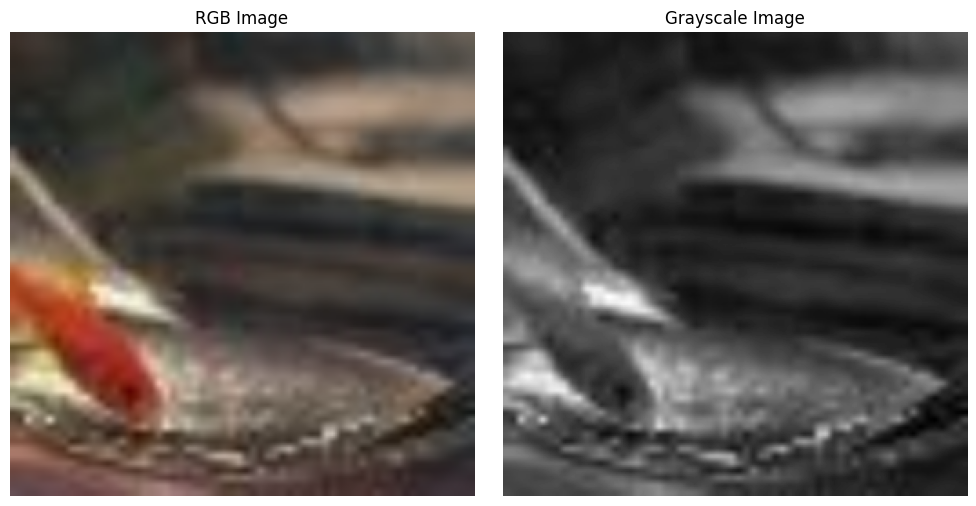

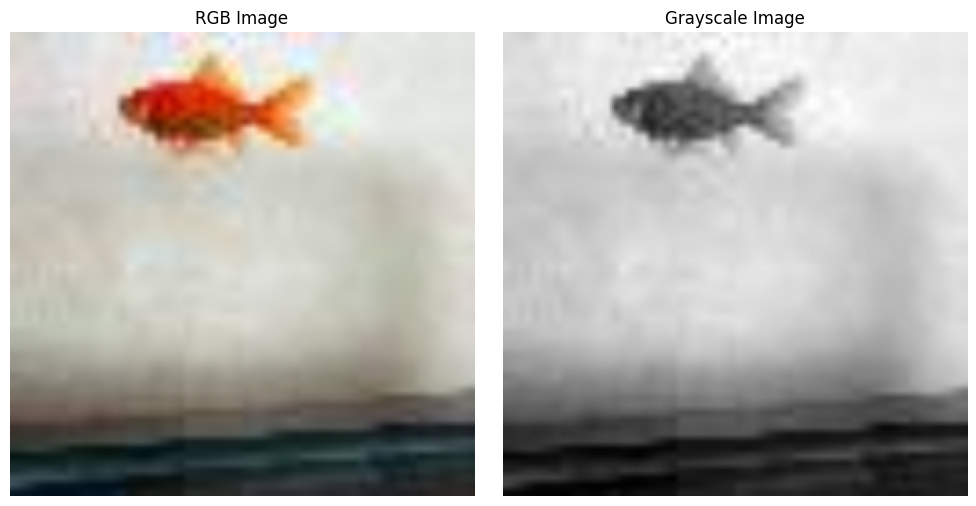

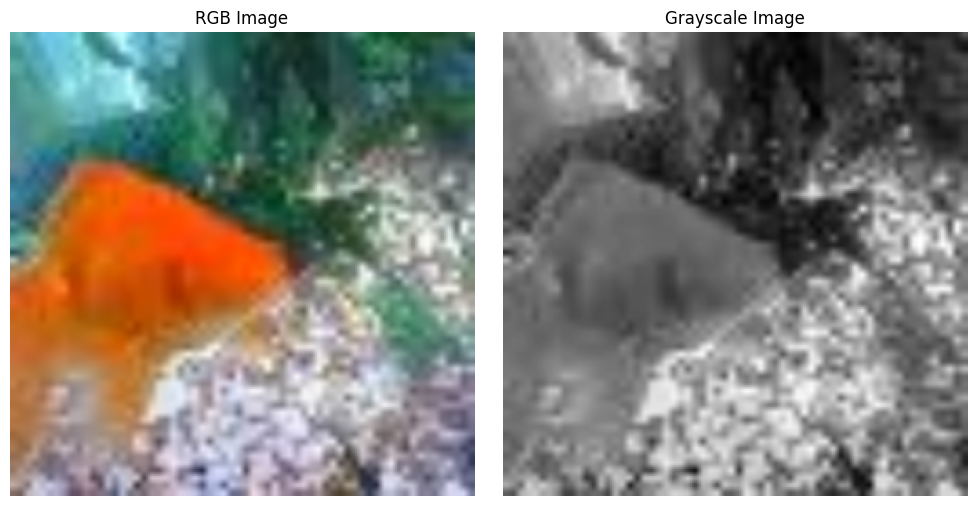

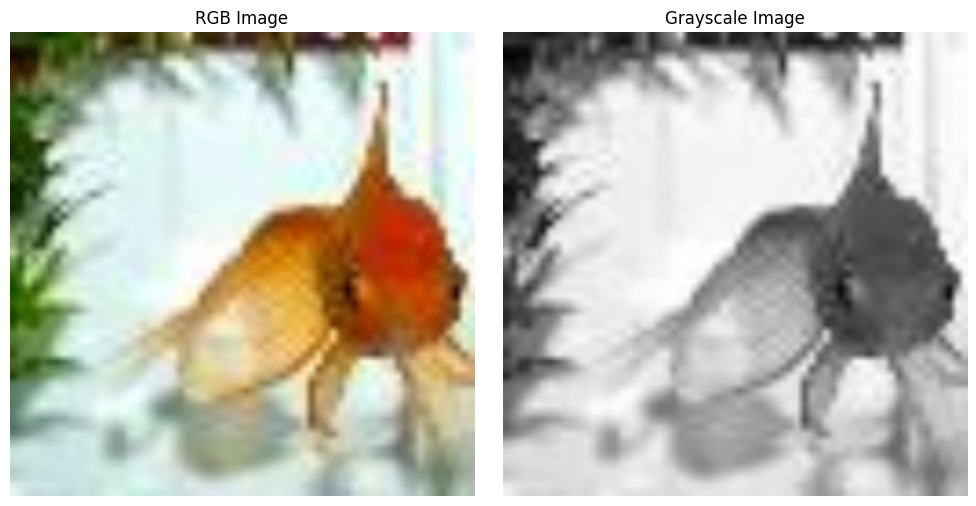

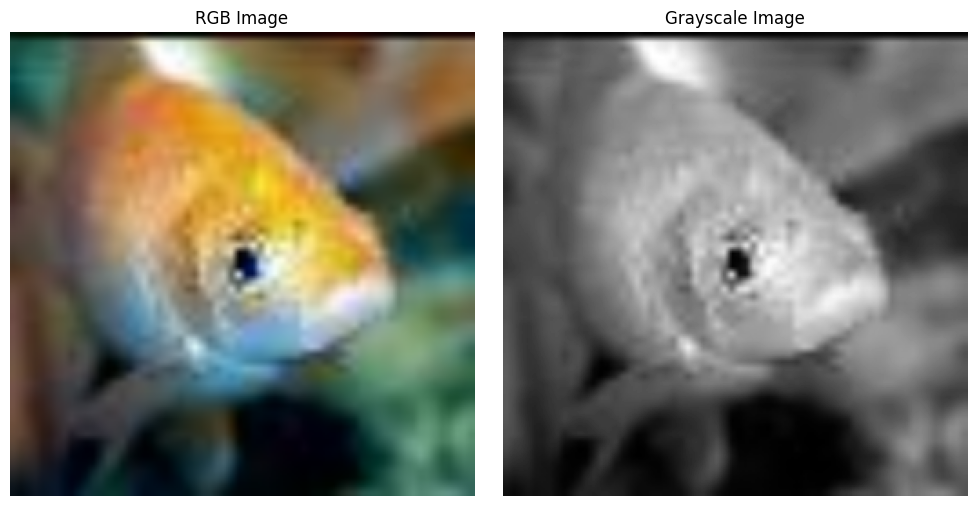

In [14]:
image_dir = "/content/tiny-imagenet-200/train/n01443537/images"
image_paths = os.listdir(image_dir)
samples = np.random.choice(image_paths, 5)
for s in samples:
    spath = os.path.join(image_dir, s)
    rgb_image, gray_image = load_rgb_gray(spath)        # Q1.1
    plot_rgb_gray(rgb_image, gray_image)                # Q1.2
    save_gray_image("/content/saves/q1", s, gray_image) # Q1.3

## **Q1.4**

In [15]:
def plot_flips(rgb_image):
    vert_flip = cv2.flip(rgb_image, 0)
    horz_flip = cv2.flip(rgb_image, 1)
    comb_flip = cv2.flip(horz_flip, 0)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.title("Original RGB Image")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(horz_flip, cv2.COLOR_BGR2RGB))
    plt.title("Horizontally Flipped")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(vert_flip, cv2.COLOR_BGR2RGB))
    plt.title("Vertically Flipped")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(comb_flip, cv2.COLOR_BGR2RGB))
    plt.title("Horiz. and Vert. Flipped")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

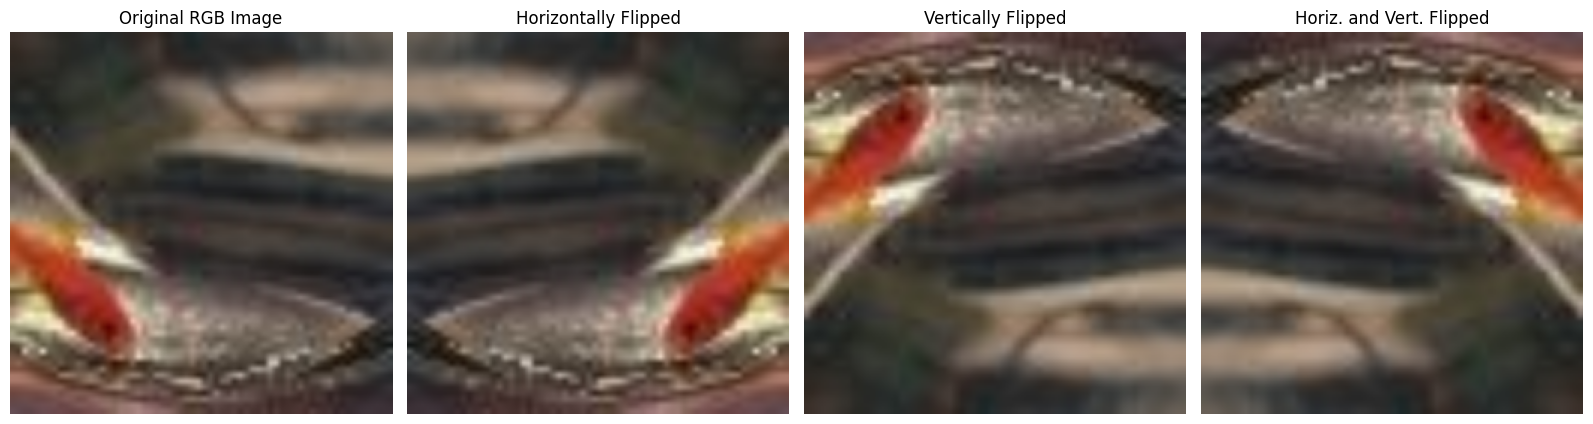

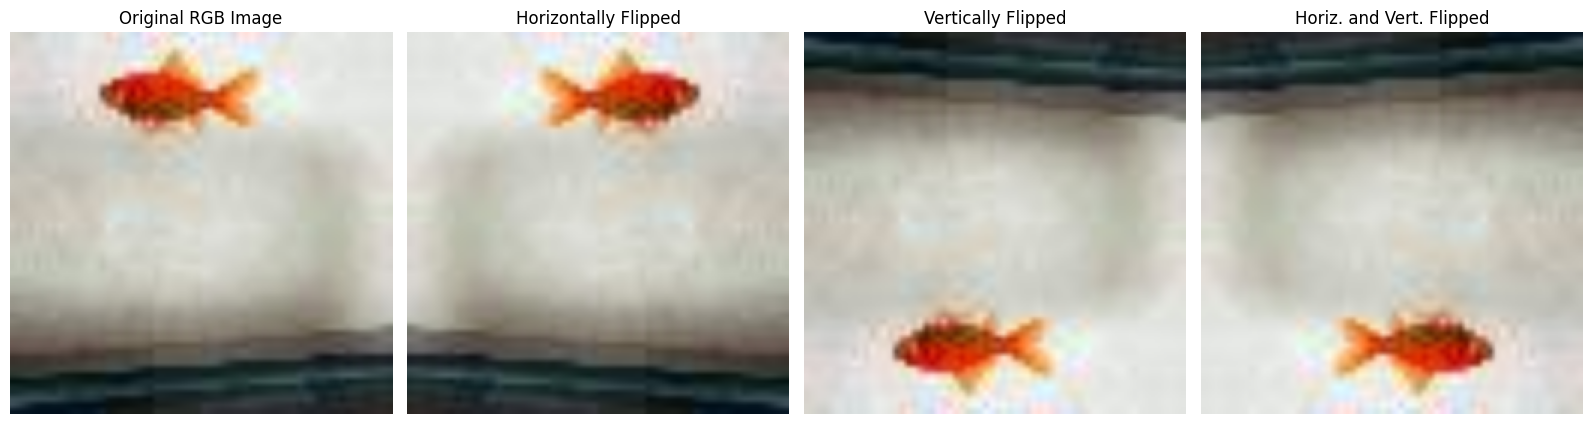

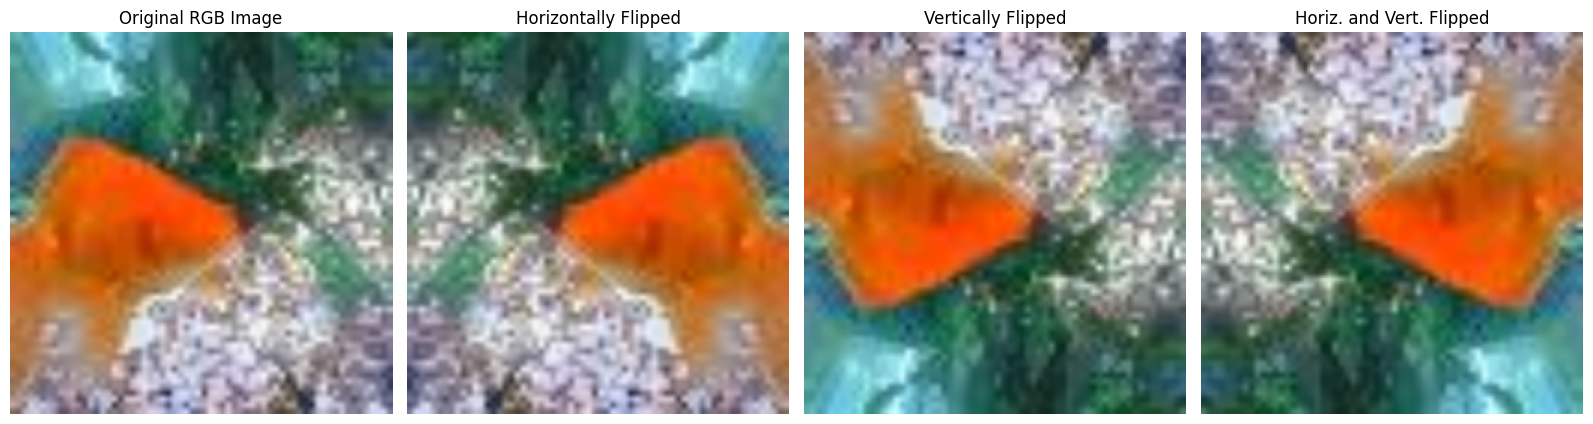

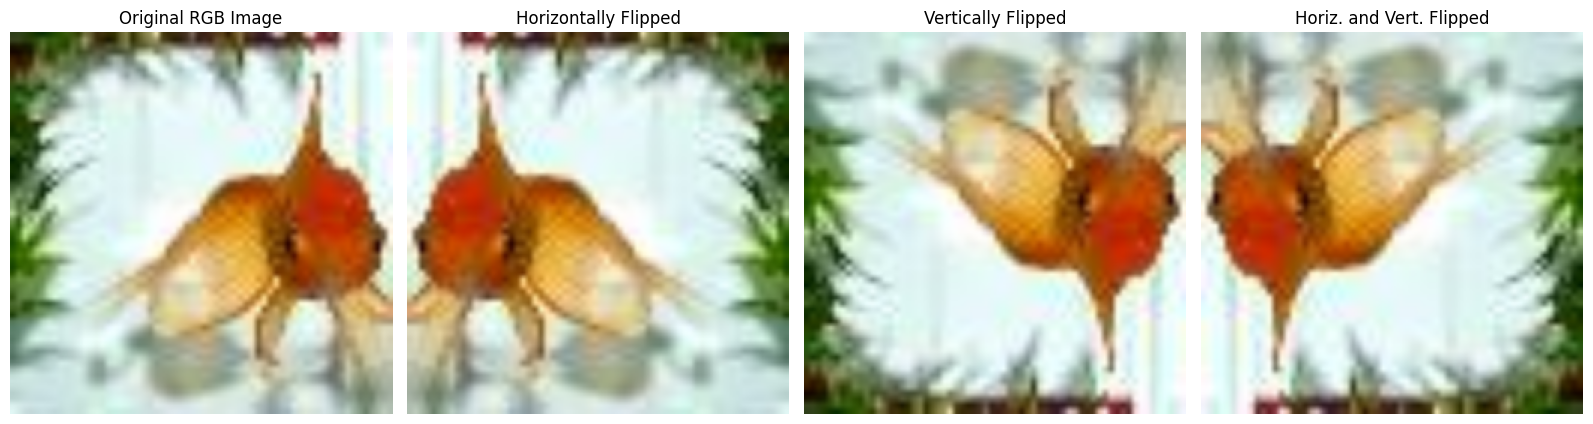

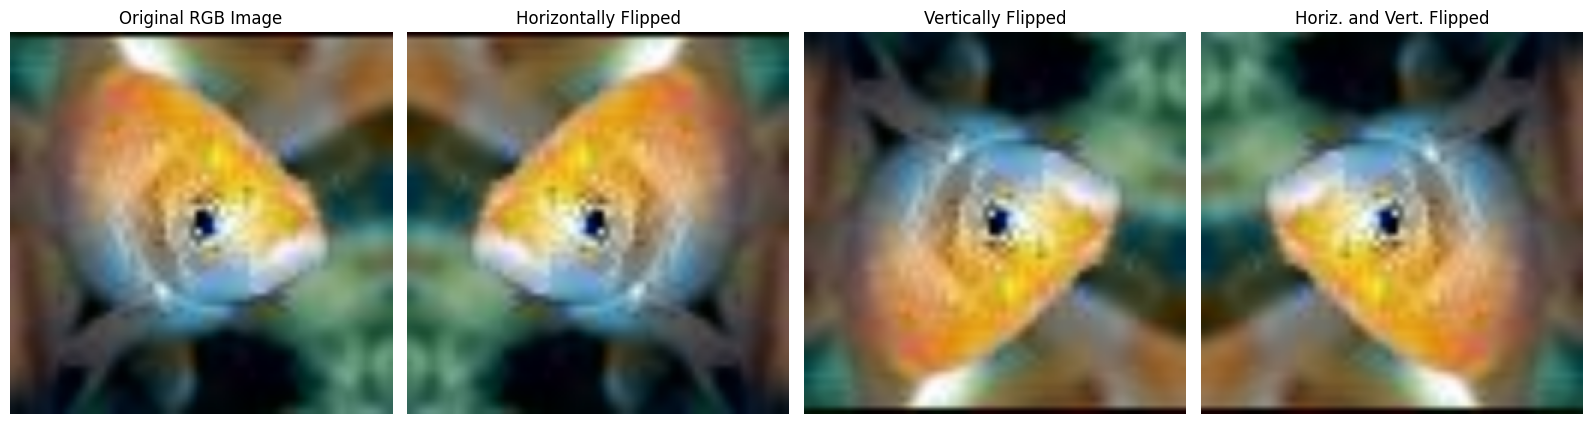

In [16]:
for s in samples:
    spath = os.path.join(image_dir, s)
    rgb_image, _ = load_rgb_gray(spath)
    plot_flips(rgb_image) # Q1.4

## **Q1.5**

In [19]:
def plot_random_crop(rgb_image, crop_shape=(128, 128)):
    centre_bounds = (0 + (crop_shape[0] // 2), 256 - (crop_shape[1] // 2))
    centre = tuple(map(int, np.random.randint(*centre_bounds, 2)))
    random_crop = cv2.getRectSubPix(rgb_image, crop_shape, centre)
    rescaled_random_crop = cv2.resize(random_crop, (256, 256))

    fig = plt.figure(figsize=(10, 5))
    rgb_image_copy = np.copy(rgb_image)
    rect_tl = (centre[0] - 64, centre[1] - 64)
    rect_br = (centre[0] + 64, centre[1] + 64)
    cv2.rectangle(rgb_image_copy, rect_tl, rect_br, (0, 255, 0), 2)
    cv2.circle(rgb_image_copy, centre, 3, (0, 0, 255), -1)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(rgb_image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Original RGB Image with crop frame and centre")

    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(rescaled_random_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Random Crop {crop_shape} and Rescaled (256, 256)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

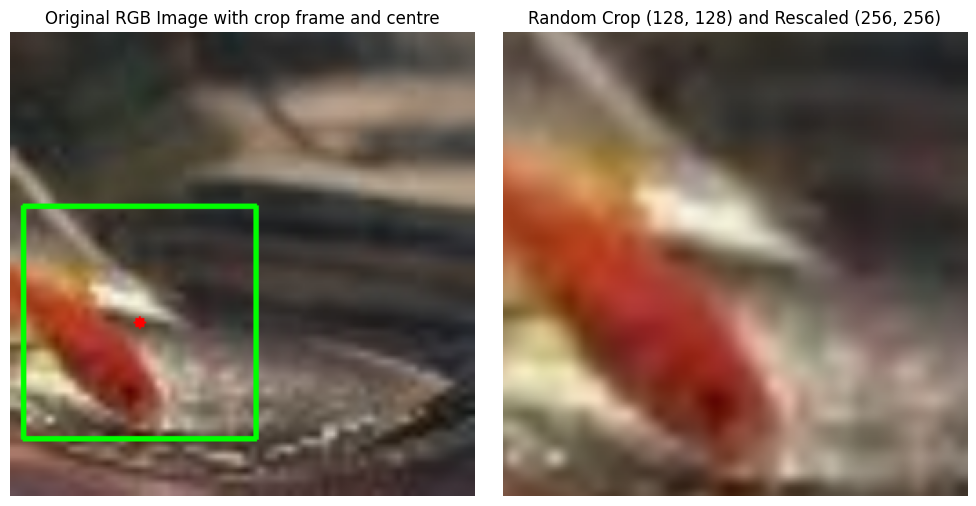

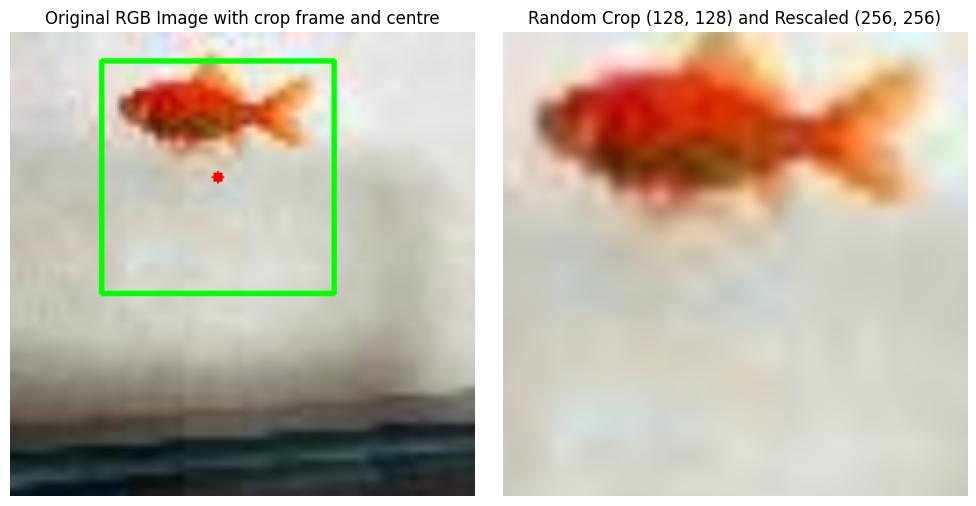

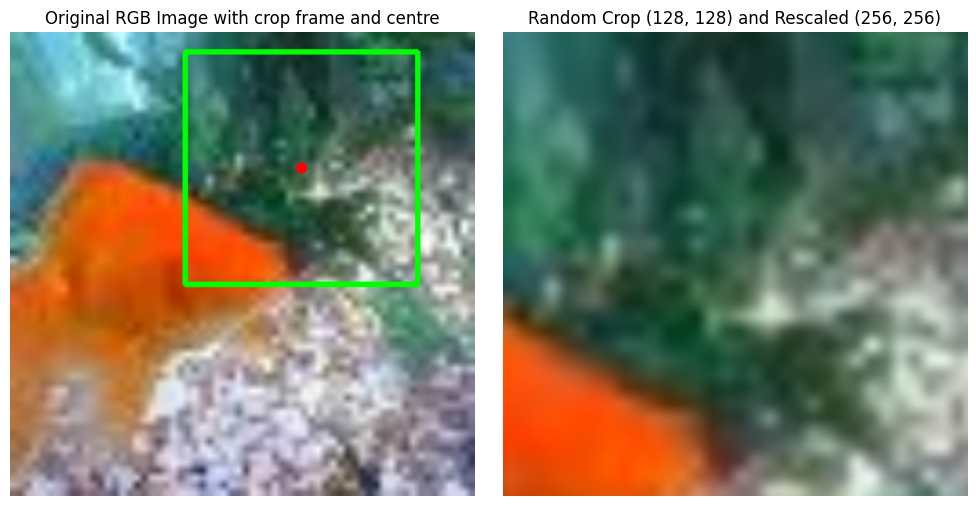

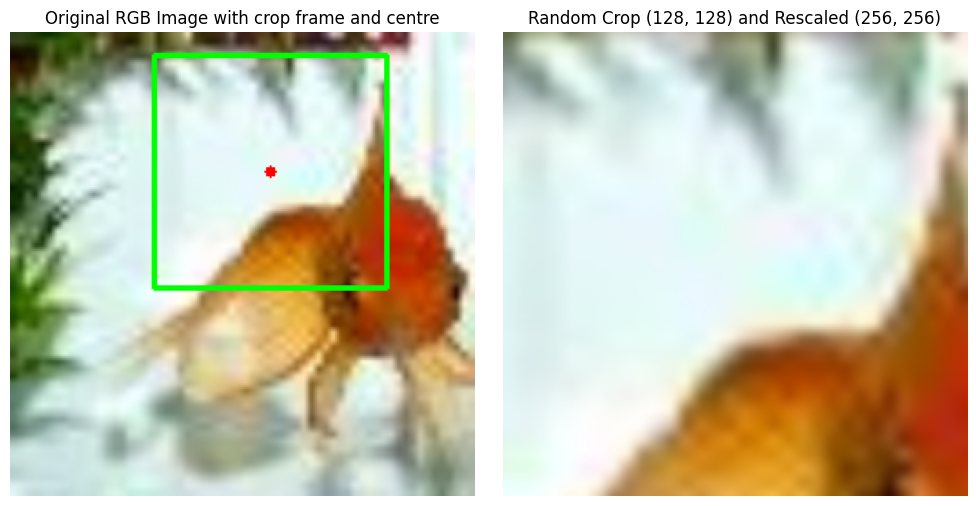

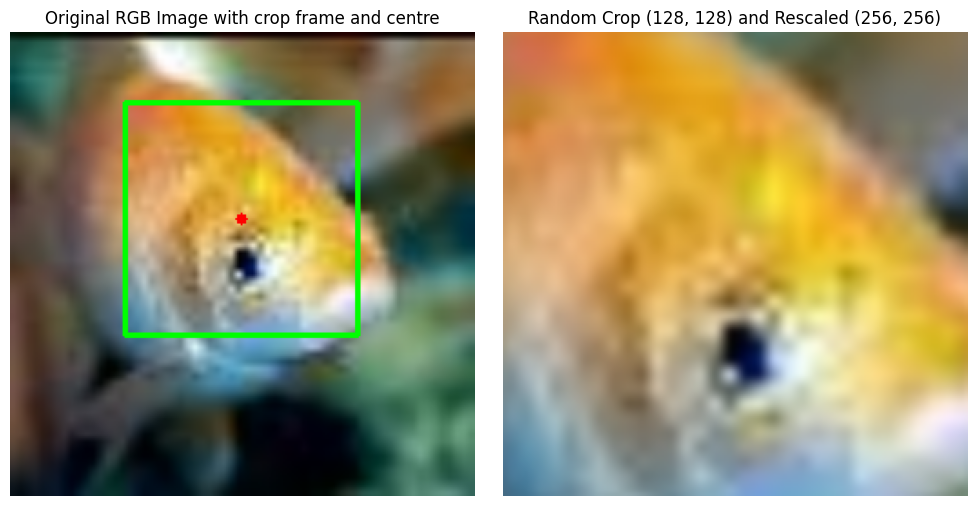

In [20]:
for s in samples:
    spath = os.path.join(image_dir, s)
    rgb_image, _ = load_rgb_gray(spath)
    plot_random_crop(rgb_image) # Q1.5

# **QUESTION2**

In [126]:
def extract_frames_from_video(video_path, save_dir, k):
    video_name = os.path.basename(video_path).split(".")[0]
    output_base_path = os.path.join(save_dir, video_name)
    if not os.path.exists(output_base_path):
        os.makedirs(output_base_path)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): raise Exception("Video cannot be opened")

    frame_num = 0
    while True:
        ret, frame = cap.read()
        if not ret: break

        if frame_num % k == 0:
            frame_resized = cv2.resize(frame, (256, 256))
            output_path = os.path.join(output_base_path, f"{frame_num}.jpg")
            cv2.imwrite(output_path, frame_resized)

        frame_num += 1

    cap.release()

In [52]:
video_path = "/content/secondary_data/person15_walking_d1_uncomp.avi"
output_folder = "/content/saves/q2"
k = 10
extract_frames_from_video(video_path, output_folder, k)

# **QUESTION3**

In [54]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


## **Q3.1**

In [102]:
def csv_histogram_from_images(images, labels, dataset_name, save_dir):
    bins = np.arange(-0.5, 256.5, 1)
    images = images.reshape(images.shape[0], -1)
    histograms = np.apply_along_axis(
        lambda img: np.histogram(img, bins=bins, range=(0, 255))[0],
        axis=1,
        arr=images,
    )
    dataset = np.column_stack((histograms, labels))
    header = [f"val_{i}" for i in range(256)] + ["label"]
    save_path = os.path.join(save_dir, dataset_name + ".csv")
    df = pd.DataFrame(dataset, columns=header)
    df.to_csv(save_path)
    print(f">> Dataset {dataset_name} processed and saved at {save_path}")
    return histograms, labels

In [ ]:
tr_his, tr_lab = csv_histogram_from_images(train_images, train_labels, "train", "/content/saves/q3")
te_his, te_lab = csv_histogram_from_images(test_images, test_labels, "test", "/content/saves/q3")

## **Q3.2**

In [117]:
tr_his = (tr_his - tr_his.min()) / (tr_his.max() - tr_his.min())
te_his = (te_his - te_his.min()) / (te_his.max() - te_his.min())

## **Q3.3**

In [ ]:
tsne_tr = TSNE(n_components=2, random_state=42)
data_tsne_tr = tsne_tr.fit_transform(tr_his)
df_tsne_tr = pd.DataFrame(
    {"tsne_1": data_tsne_tr[:, 0], "tsne_2": data_tsne_tr[:, 1], "class": tr_lab}
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="class", data=df_tsne_tr, ax=ax, s=20)
lim = (data_tsne_tr.min()-5, data_tsne_tr.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect("equal")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [ ]:
tsne_te = TSNE(n_components=2, random_state=42)
data_tsne_te = tsne_te.fit_transform(te_his)
df_tsne_te = pd.DataFrame(
    {"tsne_1": data_tsne_te[:, 0], "tsne_2": data_tsne_te[:, 1], "class": te_lab}
)
fig, ax = plt.subplots(1)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="class", data=df_tsne_te, ax=ax, s=20)
lim = (data_tsne_te.min()-5, data_tsne_te.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect("equal")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

## **Q3.4**

The weights are calculated using the least squares formula: (X^T * X)^(-1) * X^T * Y, where X is xdata_bias, and Y is y_categorical. This formula computes the weights that minimize the sum of squared differences between the predicted outputs and the actual target values.

Explanation - [StackExchange](https://math.stackexchange.com/questions/2711535/understanding-the-concept-of-xtx-1xty)

In [139]:
class LeastSquaresClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.weights = None

    def fit(self, xdata, ydata):
        y_categorical = np.eye(self.num_classes)[ydata]
        xdata_bias = np.hstack((np.ones((xdata.shape[0], 1)), xdata))
        self.weights = np.linalg.inv(xdata_bias.T @ xdata_bias) @ xdata_bias.T @ y_categorical

    def predict(self, xdata):
        xdata_bias = np.hstack((np.ones((xdata.shape[0], 1)), xdata))
        predicted_probs = xdata_bias @ self.weights
        predictions = np.argmax(predicted_probs, axis=1)
        return predictions

    def calc_accuracy(self, xdata, ydata):
        predictions = self.predict(xdata)
        accuracy = np.mean(predictions == ydata) * 100
        print(f"Accuracy: {accuracy:.2f}%")

10 Class

In [165]:
clf10 = LeastSquaresClassifier(10)
clf10.fit(tr_his, tr_lab)
clf10.calc_accuracy(te_his, te_lab)

Accuracy: 27.65%


2 Class

In [163]:
selected_classes = np.random.choice(np.unique(tr_lab), size=2, replace=False)
selected_indices = np.where(np.isin(tr_lab, selected_classes))[0]
tr_his_2 = tr_his[selected_indices]
tr_lab_2 = tr_lab[selected_indices]
tr_lab_2 = (tr_lab_2 - tr_lab_2.min()) / (tr_lab_2.max() - tr_lab_2.min())
tr_lab_2 = tr_lab_2.astype(np.int32)
selected_indices = np.where(np.isin(te_lab, selected_classes))[0]
te_his_2 = te_his[selected_indices]
te_lab_2 = te_lab[selected_indices]
te_lab_2 = (te_lab_2 - te_lab_2.min()) / (te_lab_2.max() - te_lab_2.min())
te_lab_2 = te_lab_2.astype(np.int32)


In [164]:
clf2 = LeastSquaresClassifier(2)
clf2.fit(tr_his_2, tr_lab_2)
clf2.calc_accuracy(te_his_2, te_lab_2)

Accuracy: 64.41%


# **QUESTION4**

In [166]:
class PCA:
    def __init__(self, num_iterations=5):
        self.num_iterations = num_iterations
        self.eigenvalues = None
        self.eigenvectors = None
        self.weight_matrix = None

    def fit(self, X):
        num_rows, num_cols = X.shape
        covariance_matrix = (X.T @ X)
        eigenvalues = []
        eigenvectors = []
        rank_A = np.linalg.matrix_rank(covariance_matrix)
        for k in range(rank_A):
            X_prev = np.random.rand(num_cols)
            X = X_prev.copy()
            for _ in range(self.num_iterations):
                X = (covariance_matrix @ X)
                X /= np.linalg.norm(X)
            eigenvalue = ((X.T @ covariance_matrix) @ X)
            A = covariance_matrix - eigenvalue * np.outer(X, X)
            covariance_matrix = A
            eigenvalues.append(eigenvalue)
            eigenvectors.append(X)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.weight_matrix = np.column_stack(eigenvectors)

    def reduce_data(self, X):
        return X @ self.weight_matrix

    def plot_2d(self, X, y, title='PCA Plot'):
        plt.figure(figsize=(10, 6))

        for label in np.unique(y):
            indices = np.where(y == label)
            plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {label}')

        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(title)
        plt.legend()
        plt.show()


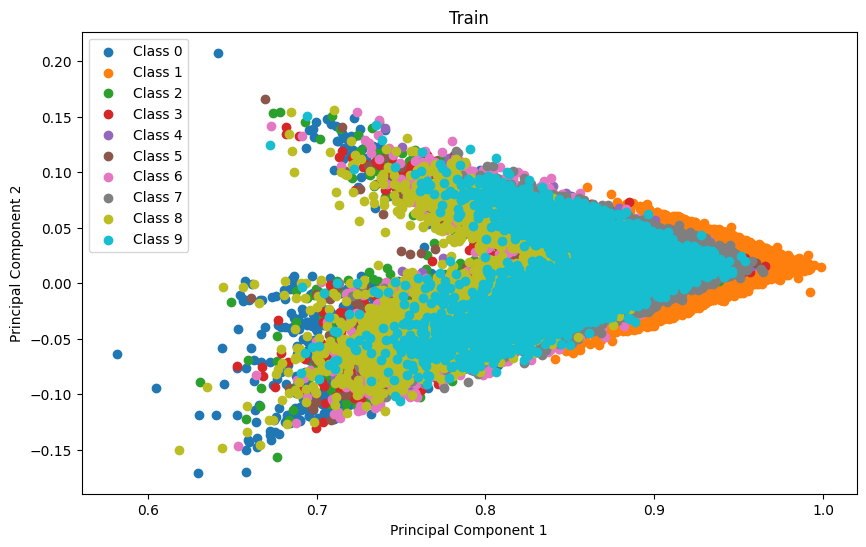

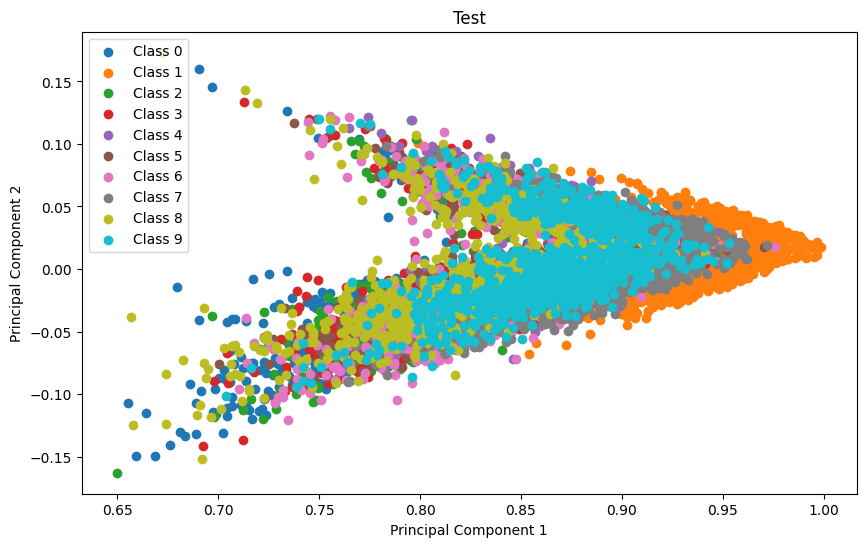

In [167]:
pca = PCA(5)
pca.fit(tr_his)
tr_his_red = pca.reduce_data(tr_his)
te_his_red = pca.reduce_data(te_his)

pca.plot_2d(tr_his_red, tr_lab, "Train")
pca.plot_2d(te_his_red, te_lab, "Test")